# Getting the Data Ready

We first need to download and unzip the dataset. 

In [ ]:
! echo "Downloading the dataset, this may take a while..."
! wget https://travistorrent.testroots.org/dumps/travistorrent_8_2_2017.csv.gz

In [ ]:
! echo "Unzipping the dataset, this may take a while..."
! gunzip travistorrent_8_2_2017.csv.gz

# Importing the Required Libraries

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import time
from datetime import datetime, timezone
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
%matplotlib inline

# Loadind the Dataset

In [2]:
final_df = pd.read_csv('travistorrent_8_2_2017.csv')
final_df.shape

D:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (3,6,18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(3702595, 62)

# Preprocessing

In this section we are going to do some preprocessing on the dataset to make it ready for learning and visualization. Preprocessing is fully explained in section V-A of the report.

## Removing Irrelevant Data

In [3]:
print('tr_duration<=0:', sum(final_df['tr_duration']<=0))
print('gh_team_size<=0:', sum(final_df['gh_team_size']<=0))
print('tr_log_testduration<0:', sum(final_df['tr_log_testduration']<=0))
print('gh_num_pr_comments<0:', sum(final_df['gh_num_pr_comments']<0))

tr_duration<=0: 920
gh_team_size<=0: 4855
tr_log_testduration<0: 142281
gh_num_pr_comments<0: 0


In [4]:
final_df = final_df.drop(final_df[final_df['tr_duration']<=0].index.values)
final_df = final_df.drop(final_df[final_df['gh_team_size']<=0].index.values)
final_df = final_df.drop(final_df[final_df['tr_log_testduration']<=0].index.values)
final_df.shape

(3554584, 62)

## Selecting Features

In [5]:
# Changed after checking VIF values from R.
# final_df = final_df[['tr_status', 'gh_is_pr', 'gh_lang', 'git_branch', 'gh_num_commits_in_push', 'gh_team_size',
# 'gh_num_commit_comments', 'git_diff_src_churn', 'git_diff_test_churn', 'gh_diff_doc_files', 'gh_diff_other_files', 
# 'gh_num_commits_on_files_touched', 'gh_sloc', 'gh_asserts_cases_per_kloc', 'gh_by_core_team_member',
# 'git_prev_commit_resolution_status', 'gh_pushed_at', 'gh_diff_files_added', 'gh_diff_files_deleted', 'gh_diff_files_modified']]
# final_df.shape
# final_df.isna().sum()

In [6]:
final_df = final_df[['tr_status', 'gh_is_pr', 'gh_lang', 'git_branch', 'gh_num_commits_in_push', 'gh_team_size',
'gh_num_commit_comments', 'git_diff_src_churn', 'git_diff_test_churn', 'gh_diff_doc_files', 'gh_diff_other_files', 
'gh_num_commits_on_files_touched', 'gh_sloc', 'gh_asserts_cases_per_kloc', 'gh_by_core_team_member',
'git_prev_commit_resolution_status', 'gh_pushed_at', 'gh_project_name']]

In [7]:
final_df.shape

(3554584, 18)

## Handling Missing Values

In [8]:
final_df = final_df.dropna()
final_df.shape

(2844789, 18)

## Modifying  Build  Status  Field

In [9]:
frames = [final_df[final_df['tr_status']=='passed'], final_df[final_df['tr_status']=='failed'],
          final_df[final_df['tr_status']=='errored']]
learning_df = pd.concat(frames)
learning_df = learning_df.replace('errored', 'failed')
learning_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2812754 entries, 5370 to 3701199
Data columns (total 18 columns):
tr_status                            object
gh_is_pr                             bool
gh_lang                              object
git_branch                           object
gh_num_commits_in_push               float64
gh_team_size                         int64
gh_num_commit_comments               int64
git_diff_src_churn                   int64
git_diff_test_churn                  int64
gh_diff_doc_files                    int64
gh_diff_other_files                  int64
gh_num_commits_on_files_touched      int64
gh_sloc                              int64
gh_asserts_cases_per_kloc            float64
gh_by_core_team_member               bool
git_prev_commit_resolution_status    object
gh_pushed_at                         object
gh_project_name                      object
dtypes: bool(2), float64(2), int64(8), object(6)
memory usage: 370.2+ MB


## Modifying Feature Fields

In [10]:
learning_df['gh_pushed_at'] = learning_df['gh_pushed_at'].apply(lambda x: 
                                                             datetime.strptime(x, '%Y-%m-%d %H:%M:%S').replace(
                                                             tzinfo=timezone.utc).timestamp())


learning_df['is_master_branch'] = learning_df['git_branch'].apply(lambda x: 1 if x == 'master' else 0)
learning_df = learning_df.drop('git_branch', axis=1)

le = LabelEncoder()
learning_df['tr_status'] = le.fit_transform(list(learning_df['tr_status']))
le = LabelEncoder()
learning_df['gh_lang'] = le.fit_transform(list(learning_df['gh_lang']))
le = LabelEncoder()
learning_df['git_prev_commit_resolution_status'] = le.fit_transform(list(learning_df['git_prev_commit_resolution_status']))
learning_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2812754 entries, 5370 to 3701199
Data columns (total 18 columns):
tr_status                            int64
gh_is_pr                             bool
gh_lang                              int64
gh_num_commits_in_push               float64
gh_team_size                         int64
gh_num_commit_comments               int64
git_diff_src_churn                   int64
git_diff_test_churn                  int64
gh_diff_doc_files                    int64
gh_diff_other_files                  int64
gh_num_commits_on_files_touched      int64
gh_sloc                              int64
gh_asserts_cases_per_kloc            float64
gh_by_core_team_member               bool
git_prev_commit_resolution_status    int64
gh_pushed_at                         float64
gh_project_name                      object
is_master_branch                     int64
dtypes: bool(2), float64(3), int64(12), object(1)
memory usage: 370.2+ MB


In [11]:
visualizing_df = learning_df.copy()
learning_df = learning_df.drop('gh_project_name', axis=1)
for i in learning_df.columns.values:
        if learning_df[i].dtype != float:
            learning_df[i] = learning_df[i].astype(float)
learning_df['random'] = np.random.random(size=learning_df.shape[0])
training_df, test_df = train_test_split(learning_df, test_size=0.3)
learning_df.head()

,tr_status,gh_is_pr,gh_lang,gh_num_commits_in_push,gh_team_size,gh_num_commit_comments,git_diff_src_churn,git_diff_test_churn,gh_diff_doc_files,gh_diff_other_files,gh_num_commits_on_files_touched,gh_sloc,gh_asserts_cases_per_kloc,gh_by_core_team_member,git_prev_commit_resolution_status,gh_pushed_at,is_master_branch,random
5370,1.0,0.0,2.0,9.0,4.0,0.0,8.0,0.0,0.0,1.0,32.0,222.0,193.693694,1.0,0.0,1.361958e+09,0.0,0.676546
5371,1.0,0.0,2.0,9.0,4.0,0.0,8.0,0.0,0.0,1.0,32.0,222.0,193.693694,1.0,0.0,1.361958e+09,0.0,0.273941
5389,1.0,0.0,2.0,9.0,4.0,0.0,64.0,0.0,0.0,2.0,87.0,222.0,193.693694,1.0,1.0,1.361958e+09,0.0,0.841288
5390,1.0,0.0,2.0,9.0,4.0,0.0,64.0,0.0,0.0,2.0,87.0,222.0,193.693694,1.0,1.0,1.361958e+09,0.0,0.789776
7983,1.0,0.0,2.0,9.0,4.0,0.0,6.0,0.0,0.0,1.0,16.0,222.0,193.693694,1.0,1.0,1.361958e+09,0.0,0.121020


## Finding Collinearities
In the following cell, we generate the scaled version of the dataframe to use it in R logistic regression

In [12]:
# The scaled dataframe
scaled_learning_df = learning_df.copy()
scale = StandardScaler()
for i in learning_df.columns.values:
        scaled_learning_df[i] = scale.fit_transform(learning_df[[i]])
scaled_learning_df['tr_status'] = learning_df['tr_status']
scaled_learning_df.head()

,tr_status,gh_is_pr,gh_lang,gh_num_commits_in_push,gh_team_size,gh_num_commit_comments,git_diff_src_churn,git_diff_test_churn,gh_diff_doc_files,gh_diff_other_files,gh_num_commits_on_files_touched,gh_sloc,gh_asserts_cases_per_kloc,gh_by_core_team_member,git_prev_commit_resolution_status,gh_pushed_at,is_master_branch,random
5370,1.0,-0.456279,0.37116,2.394279,-0.555181,-0.102285,-0.054718,-0.064895,-0.03759,0.025645,-0.161005,-0.463092,-0.166848,0.360421,-0.624657,-1.417577,-1.635288,0.690376
5371,1.0,-0.456279,0.37116,2.394279,-0.555181,-0.102285,-0.054718,-0.064895,-0.03759,0.025645,-0.161005,-0.463092,-0.166848,0.360421,-0.624657,-1.417577,-1.635288,0.927450
5389,1.0,-0.456279,0.37116,2.394279,-0.555181,-0.102285,-0.010868,-0.064895,-0.03759,0.132671,-0.135955,-0.463092,-0.166848,0.360421,1.598006,-1.417577,-1.635288,0.476301
5390,1.0,-0.456279,0.37116,2.394279,-0.555181,-0.102285,-0.010868,-0.064895,-0.03759,0.132671,-0.135955,-0.463092,-0.166848,0.360421,1.598006,-1.417577,-1.635288,1.281101
7983,1.0,-0.456279,0.37116,2.394279,-0.555181,-0.102285,-0.056284,-0.064895,-0.03759,0.025645,-0.168293,-0.463092,-0.166848,0.360421,1.598006,-1.417577,-1.635288,-0.607382


In [13]:
scaled_learning_df.to_csv('complete_processed_scaled.csv')
del scaled_learning_df

In [1]:
!R -f r_regression.R


R version 3.5.3 (2019-03-11) -- "Great Truth"
Copyright (C) 2019 The R Foundation for Statistical Computing
Platform: x86_64-w64-mingw32/x64 (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

> data = read.csv("complete_processed_scaled.csv")
> data = data[,c(-1)]
> glmfit = glm( tr_status ~ . , data = data, family = "binomial")
> library(car)
> summary(glmfit)

Call:
glm(formula = tr_status ~ ., family = "binomial", data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  


[Previously saved workspace restored]

Warning message:
glm.fit: fitted probabilities numerically 0 or 1 occurred 
Loading required package: carData


## Training Test Split

In [14]:
train_features = training_df.drop('tr_status', axis=1).values
train_labels = training_df['tr_status'].values
test_features = test_df.drop('tr_status', axis=1).values
test_labels = test_df['tr_status'].values

# Prediction Models

## Stratified Classifier

In [15]:
dummy_regressor = DummyClassifier(strategy='stratified')
stratified = dummy_regressor

start = time.time()
model = stratified.fit(train_features, train_labels)
print('fitting for {} data took {}'.format(i, time.time() - start))

prediction = stratified.predict(test_features)
score = stratified.score(test_features, test_labels)
false_positive_rate, true_positive_rate, _ = roc_curve(test_labels, prediction)  # ROC curve
roc_auc = auc(false_positive_rate, true_positive_rate)  # Area Under Curve
precision = precision_score(test_labels, prediction)
recall = recall_score(test_labels, prediction)
f1 = f1_score(test_labels, prediction)
print('score {} precision {} recall {} f1 {} roc_auc {}'.format(score, precision, recall, f1, roc_auc))  # perfomance metrics

fitting for random data took 0.15457534790039062
score 0.5752091364699162 precision 0.6950743127264801 recall 0.696010626506928 f1 0.6955421545088805 roc_auc 0.5001254209587431


## Random Forest Classifier

**Warning:** This part of the code could take hours to run.

In [16]:
size_list = [1000, 10000, 100000, 1000000]
for i in size_list:
    training_df, test_df = train_test_split(learning_df.sample(i), test_size=0.3)

    train_features = training_df.drop('tr_status', axis=1).values
    train_labels = training_df['tr_status'].values
    test_features = test_df.drop('tr_status', axis=1).values
    test_labels = test_df['tr_status'].values
    
    random_forest = RandomForestClassifier(n_estimators=1000, max_depth=30, max_features='sqrt', class_weight='balanced')
    
    start = time.time()
    model = random_forest.fit(train_features, train_labels)
    print('fitting for {} data took {}'.format(i, time.time() - start))
    prediction = random_forest.predict(test_features)
    score = random_forest.score(test_features, test_labels)
    false_positive_rate, true_positive_rate, _ = roc_curve(test_labels, prediction)  # ROC curve
    roc_auc = auc(false_positive_rate, true_positive_rate)  # Area Under Curve
    precision = precision_score(test_labels, prediction)
    recall = recall_score(test_labels, prediction)
    f1 = f1_score(test_labels, prediction)
    print('score {} precision {} recall {} f1 {} roc_auc {}'.format(score, precision, recall, f1, roc_auc))  # perfomance metrics

fitting for 1000 data took 1.4962913990020752
score 0.74 precision 0.7592592592592593 recall 0.9403669724770642 f1 0.8401639344262296 roc_auc 0.573842022823898
fitting for 10000 data took 13.308403968811035
score 0.7413333333333333 precision 0.7412329272794389 recall 0.9639942390782525 f1 0.8380634390651085 roc_auc 0.5997724739557021
fitting for 100000 data took 162.21524667739868
score 0.8307 precision 0.8225550445647308 recall 0.9656473960821786 f1 0.8883760796466011 roc_auc 0.7424708865747166
fitting for 1000000 data took 2504.0143909454346
score 0.9523766666666666 precision 0.9470802249090441 recall 0.98675664680403 f1 0.9665114164027724 roc_auc 0.9301267997650524


### Finding important features based on random forest:

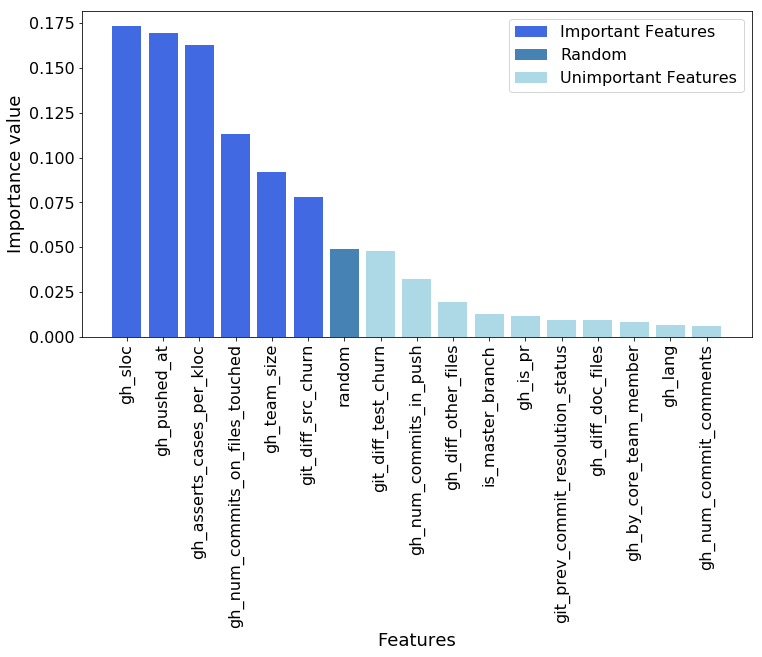

In [17]:
feature_names = training_df.drop('tr_status', axis=1).columns.values
importance = random_forest.feature_importances_
                                      
feature_names = [i for _, i in sorted(zip(importance,feature_names), reverse=True)]
importance = sorted(importance, reverse=True)

test = [[feature_names[i], importance[i]] for i in range(len(feature_names))]

for i in range(len(feature_names)):
    if feature_names[i] == 'random':
        random_index = i
        
colors = {1:'darkblue', 2:'blue', 3:'lightblue'}
f, ax = plt.subplots(figsize=(12, 6))

ax.bar(feature_names[:random_index], importance[:random_index], color='royalblue', label='Important Features')
ax.bar(feature_names[random_index], importance[random_index], color='steelblue', label='Random')
ax.bar(feature_names[random_index+1:], importance[random_index+1:], color='lightblue', label='Unimportant Features')

plt.xticks(fontsize=16, rotation=90)
plt.yticks(fontsize=16)
plt.xlabel('Features', fontsize=18)
plt.ylabel('Importance value', fontsize=18)
plt.legend(fontsize=16)
plt.savefig('Results/importance.png', dpi=300)
plt.show()

## Logistic   Regression   Classifier

In [18]:
training_df, test_df = train_test_split(learning_df, test_size=0.3)
print(training_df.shape, test_df.shape)
train_features = training_df.drop('tr_status', axis=1).values
train_labels = training_df['tr_status'].values
test_features = test_df.drop('tr_status', axis=1).values
test_labels = test_df['tr_status'].values

logit = LogisticRegression()

start = time.time()
model = logit.fit(train_features, train_labels)
print('fitting for {} data took {}'.format(i, time.time() - start))
prediction = logit.predict(test_features)
score = logit.score(test_features, test_labels)
false_positive_rate, true_positive_rate, _ = roc_curve(test_labels, prediction)  # ROC curve
roc_auc = auc(false_positive_rate, true_positive_rate)  # Area Under Curve
precision = precision_score(test_labels, prediction)
recall = recall_score(test_labels, prediction)
f1 = f1_score(test_labels, prediction)
print('score {} precision {} recall {} f1 {} roc_auc {}'.format(score, precision, recall, f1, roc_auc))  # perfomance metrics


(1968927, 18) (843827, 18)


D:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


fitting for 16 data took 10.290585041046143
score 0.6945061013691195 precision 0.6945061013691195 recall 1.0 f1 0.8197150789931953 roc_auc 0.5


### Finding important features from logistic regression

In [19]:
feature_names = training_df.drop('tr_status', axis=1).columns.values
coef = logit.coef_[0]

feature_names = [i for _, i in sorted(zip(abs(coef),feature_names), reverse=True)]
coefs = sorted(abs(coef), reverse=True)

test = [[feature_names[i], coefs[i]] for i in range(len(feature_names))]
test

[['gh_pushed_at', 5.886003731035566e-10],
 ['gh_sloc', 1.5032817782137514e-15],
 ['gh_num_commits_on_files_touched', 1.671639420081613e-16],
 ['gh_asserts_cases_per_kloc', 8.484308132527013e-17],
 ['gh_team_size', 1.5698364523744392e-17],
 ['git_diff_src_churn', 1.1133142357375047e-17],
 ['git_diff_test_churn', 8.033610759155295e-18],
 ['gh_num_commits_in_push', 8.876412056622355e-19],
 ['gh_lang', 6.328604552971948e-19],
 ['gh_by_core_team_member', 4.079305203720128e-19],
 ['is_master_branch', 3.4638027496765994e-19],
 ['git_prev_commit_resolution_status', 2.2840927740923994e-19],
 ['random', 2.0703244978400857e-19],
 ['gh_diff_other_files', 1.6650198012069055e-19],
 ['gh_is_pr', 8.144590843058831e-20],
 ['gh_num_commit_comments', 1.7324485905722863e-20],
 ['gh_diff_doc_files', 2.5710872742989925e-21]]

# Bootstrapping

## Bootstrapping on gh_is_pr Feature

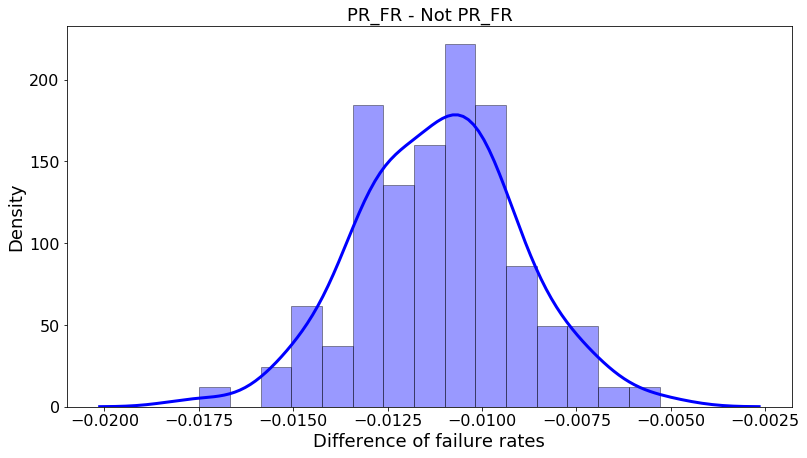

In [26]:
diffs = []
pr_dataset = learning_df[learning_df['gh_is_pr'] == 1]
non_pr_dataset = learning_df[learning_df['gh_is_pr'] == 0]
for i in range(100):
    is_pr_df = pr_dataset.sample(100000, replace=True)
    is_not_pr_df = non_pr_dataset.sample(100000, replace=True)
    
    pr_failure_rate = is_pr_df[is_pr_df['tr_status'] == 0].shape[0]/(is_pr_df[is_pr_df['tr_status'] == 0].shape[0] + is_pr_df[is_pr_df['tr_status'] == 1].shape[0])
    not_pr_failure_rate = is_not_pr_df[is_not_pr_df['tr_status'] == 0].shape[0]/(is_not_pr_df[is_not_pr_df['tr_status'] == 0].shape[0] + is_not_pr_df[is_not_pr_df['tr_status'] == 1].shape[0])
    
    one_diff = pr_failure_rate - not_pr_failure_rate
    diffs.append(one_diff)    
    
ax = sns.distplot(diffs, hist=True, kde=True,
                bins=15, color='b',
                hist_kws={'edgecolor': 'black'},
                kde_kws={'linewidth': 3})
plt.xlabel('Difference of failure rates', fontsize=18)
plt.ylabel('Density', fontsize=18)
plt.title('PR_FR - Not PR_FR', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.rcParams["figure.figsize"] = (10, 7)
fig=ax.get_figure()
fig.savefig("Results/PR.png", dpi=300)

## Bootstrapping on time between commits

In [90]:
grouped = visualizing_df.groupby('gh_project_name')
x = []
y = []
num=0
toy = 0
for name, group in grouped:
    group = group.sort_values(by=['gh_pushed_at'])
    end = np.array(group['gh_pushed_at'][1:])
    start = np.array(group['gh_pushed_at'][:-1])
    time_diff = end - start
    status = group['tr_status'].iloc[1:]
    df_temp = pd.DataFrame(status)
    df_temp['time'] = time_diff
    df_temp['gh_pushed_at'] = group['gh_pushed_at'][1:]
    df_temp = df_temp[df_temp['time'] > 0]
    passed_num = sum(df_temp['tr_status'] == 1)
    failed_num = sum(df_temp['tr_status'] == 0)
    if (failed_num + passed_num) > 0:
        y.append(failed_num / (failed_num + passed_num))
        x.append(df_temp['time'].mean())
        
projects_df = pd.DataFrame({'time': x, 'failure_rate': y})

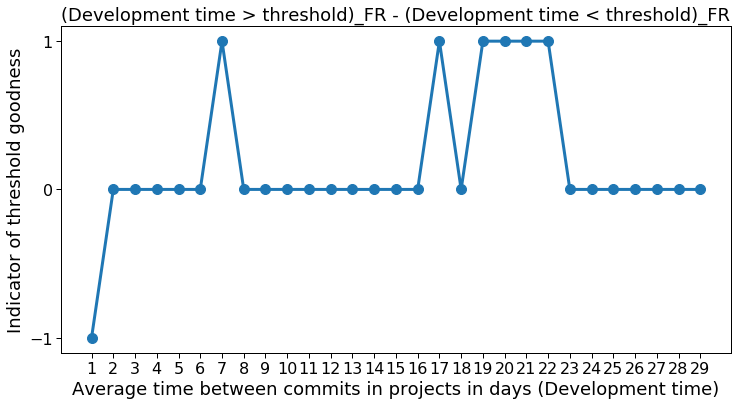

In [102]:
ranges_days =np.array(range(1, 30))
ranges = ranges_days * (86400)
stat_states= []
for i in ranges:
    less_than_dataset = projects_df[projects_df['time'] < i]
    more_than_dataset = projects_df[projects_df['time'] > i]
    diffs = []
    for i in range(100):
        is_more_than_df = more_than_dataset.sample(more_than_dataset.shape[0], replace=True)
        is_less_than_df = less_than_dataset.sample(less_than_dataset.shape[0], replace=True)

        more_than_failure_rate = is_more_than_df['failure_rate'].mean()
        less_than_failure_rate = is_less_than_df['failure_rate'].mean()
        
        one_diff = more_than_failure_rate - less_than_failure_rate
        diffs.append(one_diff)   
        
    if sum(np.array(diffs) > 0) == len(diffs):
        stat_states.append(1)
    elif sum(np.array(diffs) < 0) == len(diffs):
        stat_states.append(-1)
    else:
        stat_states.append(0)

f, ax = plt.subplots(figsize=(12, 6))
plt.plot(ranges_days, stat_states, '-o', markersize=10, linewidth=3)
plt.xticks(ranges_days, fontsize=16)
plt.yticks([-1, 0, 1], fontsize=16)
plt.xlabel('Average time between commits in projects in days (Development time)', fontsize=18)
plt.ylabel('Indicator of threshold goodness', fontsize=18)
plt.title('(Development time > threshold)_FR - (Development time < threshold)_FR', fontsize=18)
plt.savefig("Results/Development_time.png", dpi=300)
plt.show()

## Bootstrapping on gh_team_size

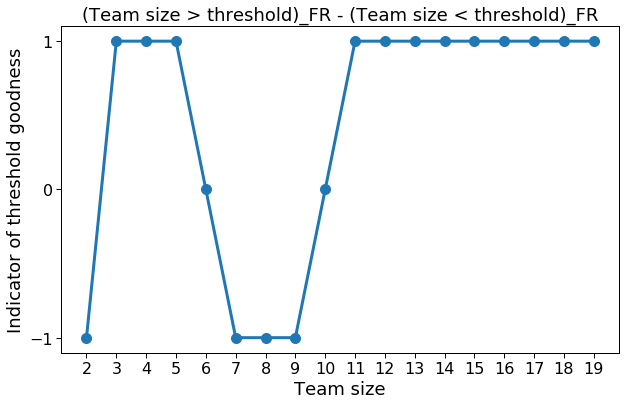

In [103]:

ranges = range(2, 20)
selected_feature = 'gh_team_size'
stat_states = []
for i in ranges:
    less_than_dataset = learning_df[learning_df['gh_team_size'] < i]
    more_than_dataset = learning_df[learning_df['gh_team_size'] > i]
    diffs = []
    for i in range(100):
        is_more_than_df = more_than_dataset.sample(100000, replace=True)
        is_less_than_df = less_than_dataset.sample(100000, replace=True)

        more_than_failure_rate = is_more_than_df[is_more_than_df['tr_status'] == 0].shape[0]/(is_more_than_df[is_more_than_df['tr_status'] == 0].shape[0] 
                                                                                       + is_pr_df[is_more_than_df['tr_status'] == 1].shape[0])
        less_than_failure_rate = is_less_than_df[is_less_than_df['tr_status'] == 0].shape[0]/(is_less_than_df[is_less_than_df['tr_status'] == 0].shape[0] 
                                                                                           + is_less_than_df[is_less_than_df['tr_status'] == 1].shape[0])

        one_diff = more_than_failure_rate - less_than_failure_rate
        diffs.append(one_diff)    

    if sum(np.array(diffs) > 0) == len(diffs):
        stat_states.append(1)
    elif sum(np.array(diffs) < 0) == len(diffs):
        stat_states.append(-1)
    else:
        stat_states.append(0)

f, ax = plt.subplots(figsize=(10, 6))
plt.plot(ranges, stat_states, '-o', markersize=10, linewidth=3)
plt.xticks(ranges, fontsize=16)
plt.yticks([-1, 0, 1], fontsize=16)
plt.xlabel('Team size', fontsize=18)
plt.ylabel('Indicator of threshold goodness', fontsize=18)
plt.title('(Team size > threshold)_FR - (Team size < threshold)_FR', fontsize=18)
plt.savefig("Results/team_size.png", dpi=300)
plt.show()

## Bootstrapping on git_diff_src_churn

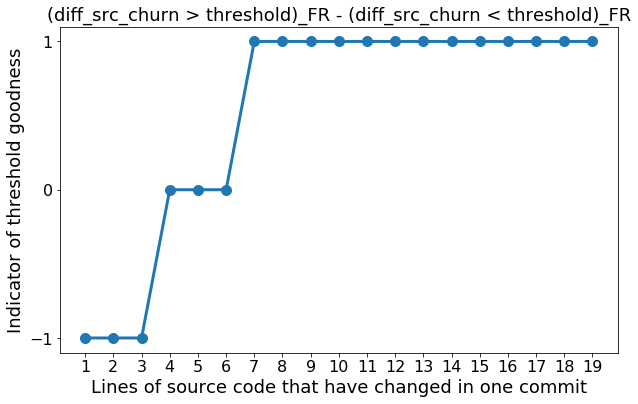

In [32]:
ranges = range(1, 20)
selected_feature = 'git_diff_src_churn'
stat_states = []
for i in ranges:
    less_than_dataset = learning_df[learning_df['git_diff_src_churn'] < i]
    more_than_dataset = learning_df[learning_df['git_diff_src_churn'] > i]
    diffs = []
    for i in range(100):
        is_more_than_df = more_than_dataset.sample(100000, replace=True)
        is_less_than_df = less_than_dataset.sample(100000, replace=True)

        more_than_failure_rate = is_more_than_df[is_more_than_df['tr_status'] == 0].shape[0]/(is_more_than_df[is_more_than_df['tr_status'] == 0].shape[0] + 
                                                                                              is_more_than_df[is_more_than_df['tr_status'] == 1].shape[0])
        less_than_failure_rate = is_less_than_df[is_less_than_df['tr_status'] == 0].shape[0]/(is_less_than_df[is_less_than_df['tr_status'] == 0].shape[0] + 
                                                                                              is_less_than_df[is_less_than_df['tr_status'] == 1].shape[0])

        one_diff = more_than_failure_rate - less_than_failure_rate
        diffs.append(one_diff)    

    if sum(np.array(diffs) > 0) == len(diffs):
        stat_states.append(1)
    elif sum(np.array(diffs) < 0) == len(diffs):
        stat_states.append(-1)
    else:
        stat_states.append(0)

f, ax = plt.subplots(figsize=(10, 6))
plt.plot(ranges, stat_states, '-o', markersize=10, linewidth=3)
plt.xticks(ranges, fontsize=16)
plt.yticks([-1, 0, 1], fontsize=16)
plt.xlabel('Lines of source code that have changed in one commit', fontsize=18)
plt.ylabel('Indicator of threshold goodness', fontsize=18)
plt.title('(diff_src_churn > threshold)_FR - (diff_src_churn < threshold)_FR', fontsize=18)
plt.savefig("Results/diff_src_churn.png", dpi=300)
plt.show()


## Bootstrapping on gh_by_core_team_member

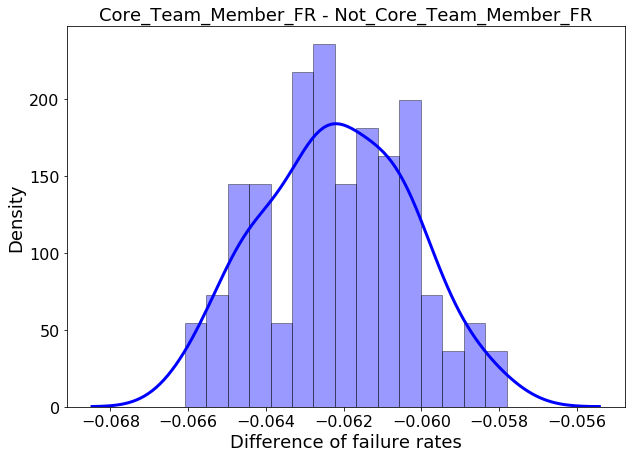

In [27]:
diffs = []
core_dataset = learning_df[learning_df['gh_by_core_team_member'] == 1]
non_core_dataset = learning_df[learning_df['gh_by_core_team_member'] == 0]
for i in range(100):
    is_core_df = core_dataset.sample(100000, replace=True)
    is_not_core_df = non_core_dataset.sample(100000, replace=True)
    
    core_failure_rate = is_core_df[is_core_df['tr_status'] == 0].shape[0]/(is_core_df[is_core_df['tr_status'] == 0].shape[0] + 
                                                                           is_core_df[is_core_df['tr_status'] == 1].shape[0])
    not_core_failure_rate = is_not_core_df[is_not_core_df['tr_status'] == 0].shape[0]/(is_not_core_df[is_not_core_df['tr_status'] == 0].shape[0] +
                                                                                       is_not_core_df[is_not_core_df['tr_status'] == 1].shape[0])
    
    one_diff = core_failure_rate - not_core_failure_rate
    diffs.append(one_diff)    
    
ax = sns.distplot(diffs, hist=True, kde=True,
                bins=15, color='b',
                hist_kws={'edgecolor': 'black'},
                kde_kws={'linewidth': 3})
plt.xlabel('Difference of failure rates', fontsize=18)
plt.ylabel('Density', fontsize=18)
plt.title('Core_Team_Member_FR - Not_Core_Team_Member_FR', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.rcParams["figure.figsize"] = (13, 7)
fig=ax.get_figure()
fig.savefig("Results/Core_Team_Member.png", dpi=300)

## Bootstrapping on git_prev_commit_resolution_status

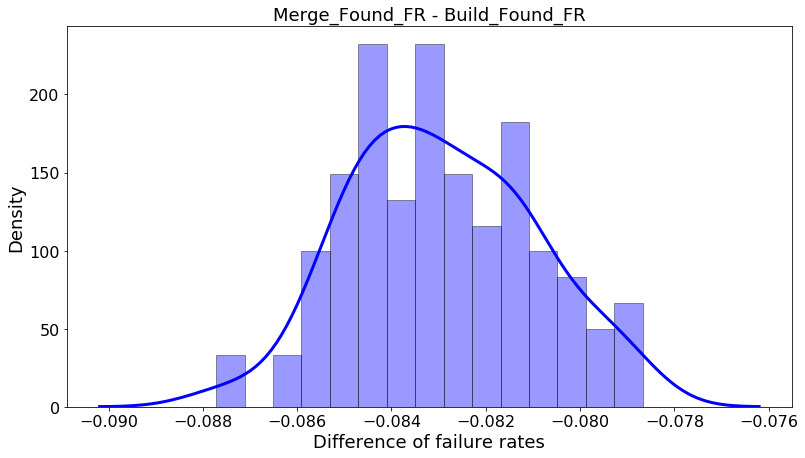

In [28]:
diffs = []
pr_dataset = learning_df[learning_df['git_prev_commit_resolution_status'] == 1]
non_pr_dataset = learning_df[learning_df['git_prev_commit_resolution_status'] == 0]
for i in range(100):
    is_pr_df = pr_dataset.sample(100000, replace=True)
    is_not_pr_df = non_pr_dataset.sample(100000, replace=True)
    
    pr_failure_rate = is_pr_df[is_pr_df['tr_status'] == 0].shape[0]/(is_pr_df[is_pr_df['tr_status'] == 0].shape[0] + is_pr_df[is_pr_df['tr_status'] == 1].shape[0])
    not_pr_failure_rate = is_not_pr_df[is_not_pr_df['tr_status'] == 0].shape[0]/(is_not_pr_df[is_not_pr_df['tr_status'] == 0].shape[0] + is_not_pr_df[is_not_pr_df['tr_status'] == 1].shape[0])
    
    one_diff = pr_failure_rate - not_pr_failure_rate
    diffs.append(one_diff)    
    
ax = sns.distplot(diffs, hist=True, kde=True,
                bins=15, color='b',
                hist_kws={'edgecolor': 'black'},
                kde_kws={'linewidth': 3})
plt.xlabel('Difference of failure rates', fontsize=18)
plt.ylabel('Density', fontsize=18)
plt.title('Merge_Found_FR - Build_Found_FR', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.rcParams["figure.figsize"] = (10, 7)
fig=ax.get_figure()
fig.savefig("Results/resolution_status.png", dpi=300)

## Bootstrapping on gh_num_commits_on_files_touched

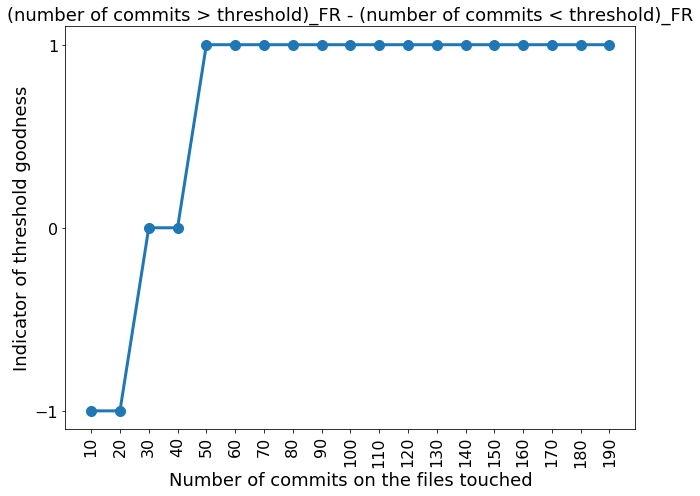

In [36]:
ranges = range(1, 20)
ranges = np.array(ranges) * 10
selected_feature = 'gh_num_commits_on_files_touched'
stat_states = []
for i in ranges:
    less_than_dataset = learning_df[learning_df['gh_num_commits_on_files_touched'] < i]
    more_than_dataset = learning_df[learning_df['gh_num_commits_on_files_touched'] > i]
    diffs = []
    for i in range(100):
        is_more_than_df = more_than_dataset.sample(100000, replace=True)
        is_less_than_df = less_than_dataset.sample(100000, replace=True)

        more_than_failure_rate = is_more_than_df[is_more_than_df['tr_status'] == 0].shape[0]/(is_more_than_df[is_more_than_df['tr_status'] == 0].shape[0] + 
                                                                                              is_more_than_df[is_more_than_df['tr_status'] == 1].shape[0])
        less_than_failure_rate = is_less_than_df[is_less_than_df['tr_status'] == 0].shape[0]/(is_less_than_df[is_less_than_df['tr_status'] == 0].shape[0] + 
                                                                                              is_less_than_df[is_less_than_df['tr_status'] == 1].shape[0])

        one_diff = more_than_failure_rate - less_than_failure_rate
        diffs.append(one_diff)    

    if sum(np.array(diffs) > 0) == len(diffs):
        stat_states.append(1)
    elif sum(np.array(diffs) < 0) == len(diffs):
        stat_states.append(-1)
    else:
        stat_states.append(0)

f, ax = plt.subplots(figsize=(10, 7))
plt.plot(ranges, stat_states, '-o', markersize=10, linewidth=3)
plt.xticks(ranges, fontsize=16, rotation=90)
plt.yticks([-1, 0, 1], fontsize=16)
plt.xlabel('Number of commits on the files touched', fontsize=18)
plt.ylabel('Indicator of threshold goodness', fontsize=18)
plt.title('(number of commits > threshold)_FR - (number of commits < threshold)_FR', fontsize=18)
plt.tight_layout()
plt.savefig("Results/files_touched.png", dpi=300)
plt.show()

## Bootstrapping on is_master_branch

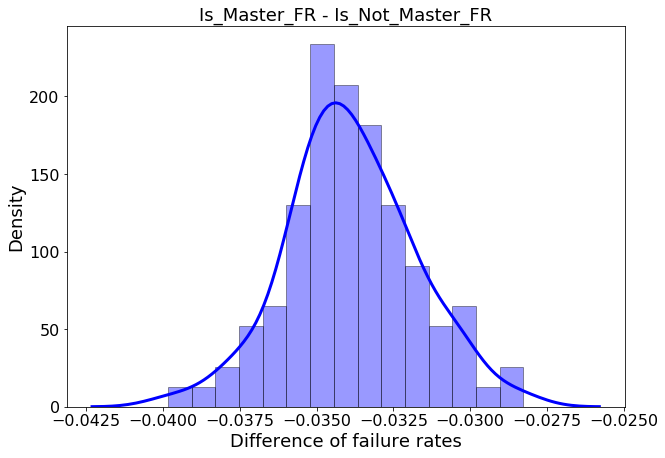

In [34]:
diffs = []
pr_dataset = learning_df[learning_df['is_master_branch'] == 1]
non_pr_dataset = learning_df[learning_df['is_master_branch'] == 0]
for i in range(100):
    is_pr_df = pr_dataset.sample(100000, replace=True)
    is_not_pr_df = non_pr_dataset.sample(100000, replace=True)
    
    pr_failure_rate = is_pr_df[is_pr_df['tr_status'] == 0].shape[0]/(is_pr_df[is_pr_df['tr_status'] == 0].shape[0] + is_pr_df[is_pr_df['tr_status'] == 1].shape[0])
    not_pr_failure_rate = is_not_pr_df[is_not_pr_df['tr_status'] == 0].shape[0]/(is_not_pr_df[is_not_pr_df['tr_status'] == 0].shape[0] + is_not_pr_df[is_not_pr_df['tr_status'] == 1].shape[0])
    
    one_diff = pr_failure_rate - not_pr_failure_rate
    diffs.append(one_diff)    
    
ax = sns.distplot(diffs, hist=True, kde=True,
                bins=15, color='b',
                hist_kws={'edgecolor': 'black'},
                kde_kws={'linewidth': 3})
plt.xlabel('Difference of failure rates', fontsize=18)
plt.ylabel('Density', fontsize=18)
plt.title('Is_Master_FR - Is_Not_Master_FR', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.rcParams["figure.figsize"] = (10, 8)
fig=ax.get_figure()
fig.savefig("Results/is_master.png", dpi=300)